# Project Template - adapted

## Imports

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *

Be sure to start the stream on Kafka!

## Create Spark Session

In [2]:
spark = (
    SparkSession.builder
        .appName("Project DPA")
        .master("local[*]")   
        .config("spark.jars.packages",
                "org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0")
        .config("spark.sql.repl.eagerEval.enabled", True)
        .getOrCreate()
)

spark.sparkContext.setLogLevel("WARN")

Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
:: loading settings :: url = jar:file:/usr/local/lib/python3.9/dist-packages/pyspark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml
org.apache.spark#spark-sql-kafka-0-10_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-5150fc86-9bee-4af4-bf67-e0671f7bef44;1.0
	confs: [default]
	found org.apache.spark#spark-sql-kafka-0-10_2.12;3.0.0 in central
	found org.apache.spark#spark-token-provider-kafka-0-10_2.12;3.0.0 in central
	found org.apache.kafka#kafka-clients;2.4.1 in central
	found com.github.luben#zstd-jni;1.4.4-3 in central
	found org.lz4#lz4-java;1.7.1 in central
	found org.xerial.snappy#snappy-java;1.1.7.5 in central
	found org.slf4j#slf4j-api;1.7.30 in central
	found org.spark-project.spark#unused;1.0.0 in central
	found org.apache.commons#commons-pool2;2.6.2 in central
:: resolution report :: resolve 280ms :: artifacts dl 7m

## Schema Definiton

In [3]:
schema = StructType([
    StructField("name", StringType()),
    StructField("price", FloatType()),
    StructField("n_shares", IntegerType()),
    StructField("timestamp", StringType())
])

# Kafka Stream Ingestion

In [4]:
# Read from Kafka topic "stock"
raw_df = (
    spark.readStream
         .format("kafka")
         .option("kafka.bootstrap.servers", "kafka1:9092")
         .option("subscribe", "stock")
         .option("startingOffsets", "latest")
         .load()
)

# Kafka sends bytes → convert to string
json_df = raw_df.selectExpr("CAST(value AS STRING)")

# Parse JSON using the schema
parsed_df = json_df.select(
    from_json(col("value"), schema).alias("data")
).select("data.*")

# Convert timestamp string into actual timestamp type
parsed_df = parsed_df.withColumn(
    "timestamp", to_timestamp("timestamp", "yyyy-MM-dd'T'HH:mm:ss'Z'")
)

# Make the dataset available to all following tasks
parsed_df.createOrReplaceTempView("stocks_stream")

# Start Streaming Output

### Task 6

Track wallet evolution

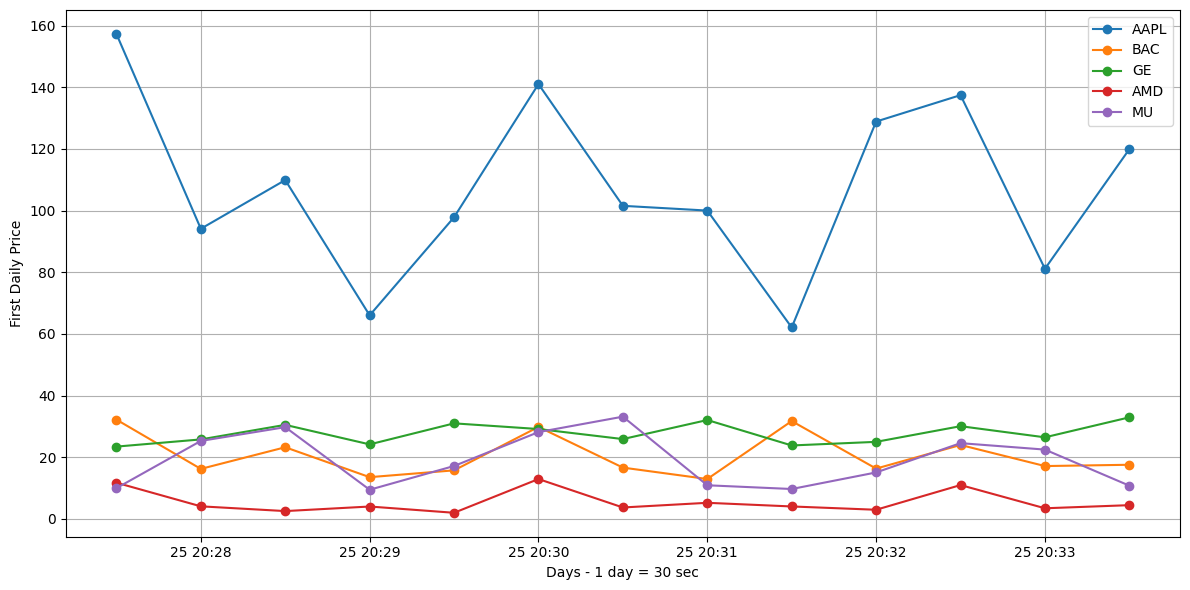


--- NEW BATCH ---
2025-11-25 20:27:30 | AAPL  | entry=157.28 | current=74.74 | n=4 | gain%=-52.48
2025-11-25 20:27:30 | BAC   | entry=32.21 | current=15.03 | n=3 | gain%=-53.34
2025-11-25 20:27:30 | GE    | entry=23.46 | current=23.46 | n=1 | gain%=0.00
2025-11-25 20:27:30 | AMD   | entry=11.75 | current=2.68 | n=2 | gain%=-77.19
2025-11-25 20:27:30 | MU    | entry=9.98 | current=14.31 | n=2 | gain%=43.39
2025-11-25 20:28:00 | GE    | entry=25.79 | current=30.25 | n=6 | gain%=17.29
2025-11-25 20:28:00 | MU    | entry=25.30 | current=28.76 | n=8 | gain%=13.68
2025-11-25 20:28:00 | AMD   | entry=4.09 | current=2.47 | n=4 | gain%=-39.61
2025-11-25 20:28:00 | BAC   | entry=16.23 | current=17.83 | n=5 | gain%=9.87
2025-11-25 20:28:00 | AAPL  | entry=94.10 | current=111.37 | n=7 | gain%=18.35
2025-11-25 20:28:30 | BAC   | entry=23.25 | current=22.62 | n=2 | gain%=-2.71
2025-11-25 20:28:30 | AAPL  | entry=109.90 | current=175.39 | n=8 | gain%=59.59
2025-11-25 20:28:30 | AMD   | entry=2.55 | 

In [ ]:
from pyspark.sql import functions as F
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

STOCKS = ["BAC", "AAPL", "MU", "AMD", "GE"]
MAX_WINDOWS = 20  # Maximum windows before automatic stop

filtered_df = parsed_df.filter(F.col("name").isin(STOCKS))

# Streaming query: 30s window, memory
query6 = (
    filtered_df
    .withColumn("timestamp", F.col("timestamp").cast("timestamp"))
    .groupBy(
        F.window("timestamp", "30 seconds"),
        "name"
    )
    .agg(
        F.first("price").alias("entry_price"),
        F.last("price").alias("current_price"),
        F.count("*").alias("n_events"),
        ((F.last("price") - F.first("price")) / F.first("price") * 100).alias("gain_percentage")
    )
    .writeStream
    .format("memory")
    .outputMode("complete")
    .queryName("task6_memory")
    .trigger(processingTime="5 seconds")
    .start()
)

print("\n--- Query streaming multi-stock started\n")

# live console + live plot
plt.ion()
print("--- Starting live graph\n")

windows_seen = 0

while True:
    
    # Read table
    df_live = spark.sql("""
        SELECT
            window.start AS start,
            name,
            entry_price,
            current_price,
            n_events,
            gain_percentage
        FROM task6_memory
        ORDER BY start
    """)

    rows = df_live.collect()

    # Console output (batches)
    if len(rows) > 0:
        print("\n--- NEW BATCH ---")
        for r in rows:
            print(f"{r['start']} | {r['name']:5} | entry={r['entry_price']:.2f} | current={r['current_price']:.2f} | n={r['n_events']} | gain%={r['gain_percentage']:.2f}")

        # Live plot
        clear_output(wait=True)
        from collections import defaultdict
        serie = defaultdict(lambda: {"x": [], "y": []})

        for r in rows:
            serie[r["name"]]["x"].append(r["start"])
            serie[r["name"]]["y"].append(r["entry_price"])

        plt.figure(figsize=(12, 6))
        for stock, data in serie.items():
            plt.plot(data["x"], data["y"], marker='o', label=stock)

        plt.xlabel("Days - 1 day = 30 sec")
        plt.ylabel("First Daily Price")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

        # Count windows and stop if MAX_WINDOWS reached
        unique_windows = sorted(list({r['start'] for r in rows}))
        windows_seen = len(unique_windows)
        if windows_seen >= MAX_WINDOWS:
            print(f"\n>>> AUTOMATIC STOP: reached {MAX_WINDOWS} windows")
            query6.stop()
            break

    time.sleep(5)
